In [25]:
!pip install ultralytics keras-facenet

# **Import libraries**

In [39]:
from ultralytics import YOLO
import os
import cv2
from PIL import Image
import numpy as np
from keras.models import load_model
import random
from keras_facenet import FaceNet
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
import pickle
import pandas as pd
from google.colab.patches import cv2_imshow

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Load data**
### *Load the dataset and divide it into a ratio of 80% for the training set and 20% for the validation set (If you need to train from begining)*

In [4]:
#load all file_paths of person to corresponding label
def get_all_image_name_per_person(path):
  all_name_files = os.listdir(path)
  return all_name_files

file_path = '/content/drive/MyDrive/Biometrics/105_classes_pins_dataset'
all_folders_of_celebs = os.listdir(file_path)
list_celebs = {}
for folder in all_folders_of_celebs:
  path_folder = os.path.join(file_path,folder)
  all_files_per_person = get_all_image_name_per_person(path_folder)
  list_celebs[folder.replace("pins_","")] = [os.path.join(path_folder, file) for file in all_files_per_person]

#split data with 80% train and 20% val
train_celebs = {}
val_celebs = {}
split_ratio = 0.8
for key, values in list_celebs.items():
    split_index = int(len(values) * split_ratio)
    random.shuffle(values)

    train_values = values[:split_index]
    val_values = values[split_index:]

    train_celebs[key] = train_values
    val_celebs[key] = val_values

# **Use YOLOv8 Model for Face Detection**

In [8]:
def crop_image(original_image, coordinate):
    cropped_image = original_image[int(coordinate[1]):int(coordinate[3]), int(coordinate[0]):int(coordinate[2])]
    cropped_image = cv2.resize(cropped_image, (160,160))
    return cropped_image

In [4]:
###Load weights
YOLO_model = YOLO('/content/drive/MyDrive/Biometrics/yolov8n-face.pt')

WARNING ⚠️ /content/drive/MyDrive/Biometrics/HW2/yolov8n-face.pt appears to require 'omegaconf', which is not in ultralytics requirements.
AutoInstall will run now for 'omegaconf' but this feature will be removed in the future.
Recommend fixes are to train a new model using the latest 'ultralytics' package or to run a command with an official YOLOv8 model, i.e. 'yolo predict model=yolov8n.pt'
requirements: Ultralytics requirement ['omegaconf'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 12.9 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=56662d6961b13d38d679574511e60c8670608ad43106348c8d9eb93a5e892f6b
  Stored in directory: /tmp/pip-ephem-wheel-cache-577cwzf6/wheels/12

In [7]:
#extract all faces to corresponding label
def detect_faces(data):
  list_faces = list()
  labels = list()
  cnt = 0
  for person in data:
    print(cnt)
    for file in data[person]:
      img = cv2.imread(file)
      if img is None:
        continue
      face = YOLO_model(file, conf = 0.6)
      coordinate_s = face[0].cpu().boxes.xyxy.tolist()
      if len(coordinate_s) == 1:
        [x1, y1, x2, y2] = coordinate_s[0]
        cropped_image = crop_image(img, [x1, y1, x2, y2])
        list_faces.append(cropped_image)
        labels.append(person)
    cnt+=1
  return np.asarray(list_faces), np.asarray(labels)

train_images, train_labels = detect_faces(train_celebs)
val_images, val_labels = detect_faces(val_celebs)


Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
image 1/1 /content/drive/MyDrive/Biometrics/HW2/105_classes_pins_dataset/pins_Katharine Mcphee/Katharine Mcphee70_1673.jpg: 640x608 (no detections), 10.2ms
Speed: 2.8ms preprocess, 10.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)

image 1/1 /content/drive/MyDrive/Biometrics/HW2/105_classes_pins_dataset/pins_Katharine Mcphee/Katharine Mcphee84_1680.jpg: 640x512 (no detections), 9.8ms
Speed: 2.2ms preprocess, 9.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 /content/drive/MyDrive/Biometrics/HW2/105_classes_pins_dataset/pins_Katharine Mcphee/Katharine Mcphee20_1603.jpg: 640x608 1 face, 12.5ms
Speed: 2.3ms preprocess, 12.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 608)

image 1/1 /content/drive/MyDrive/Biometrics/HW2/105_classes_pins_dataset/pins_Katharine Mcphee/Katharine Mcphee96_1690.jpg: 640x608 1 face, 10.3ms
Speed: 2.6ms preprocess, 10.3ms inference, 1.

In [8]:
##save cropped-images for further use
np.save('/content/drive/MyDrive/Biometrics/train_images.npy', train_images)
np.save('/content/drive/MyDrive/Biometrics/train_labels', train_labels)
np.save('/content/drive/MyDrive/Biometrics/val_images.npy', val_images)
np.save('/content/drive/MyDrive/Biometrics/val_labels.npy', val_labels)

# **Use FaceNet for Face Embedding**

In [5]:
embedder = FaceNet()

In [27]:
train_embeddings = embedder.embeddings(train_images)
val_embeddings = embedder.embeddings(val_images)

97/97 [==============================] - 4s 46ms/step


In [67]:
np.save('/content/drive/MyDrive/Biometrics/train_embeddings.npy', train_embeddings)
np.save('/content/drive/MyDrive/Biometrics/val_embeddings.npy', val_embeddings)

# **Use SVM for Face Recognition**

In [30]:
in_encoder = Normalizer()
emdTrainX_norm = in_encoder.transform(train_embeddings)
emdValX_norm = in_encoder.transform(val_embeddings)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(train_labels)
trainy_enc = out_encoder.transform(train_labels)
valy_enc = out_encoder.transform(val_labels)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(emdTrainX_norm, trainy_enc)
# predict
yhat_train = model.predict(emdTrainX_norm)
yhat_val = model.predict(emdValX_norm)

In [ ]:
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(emdTrainX_norm, trainy_enc)
# predict
yhat_train = model.predict(emdTrainX_norm)
yhat_val = model.predict(emdValX_norm)

In [69]:
###save for further use
support_vectors_file = '/content/drive/MyDrive/Biometrics/SVM.pickle'
pickle.dump(model, open(support_vectors_file, "wb"))

# **Evaluate**

In [82]:
def evaluate(labels, predictions):
  accuracy = metrics.accuracy_score(labels, predictions)
  precision = metrics.precision_score(labels, predictions,average='micro')
  recall = metrics.recall_score(labels, predictions,average='micro')
  f1 = metrics.f1_score(labels, predictions,average='micro')

  result_df = pd.DataFrame({
      'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
      'Score': [accuracy, precision, recall, f1]
  })
  return result_df

### *Train*

In [83]:
result_train = evaluate(trainy_enc, yhat_train)
result_train

,Metric,Score
0,Accuracy,0.995742
1,Precision,0.995742
2,Recall,0.995742
3,F1 Score,0.995742


### *Val*

In [84]:
result_val = evaluate(valy_enc, yhat_val)
result_val

,Metric,Score
0,Accuracy,0.981565
1,Precision,0.981565
2,Recall,0.981565
3,F1 Score,0.981565


# **Predict some images with single faces**

In [34]:
SVM_model = pickle.load(open('/content/drive/MyDrive/Biometrics/SVM.pickle', 'rb'))

In [35]:
def predict(file_path, model):
  face = YOLO_model(file_path, conf = 0.5)
  coordinate_s = face[0].cpu().boxes.xyxy.tolist()
  [x1, y1, x2, y2]=coordinate_s[0]
  cropped_image = crop_image(cv2.imread(file_path), [x1, y1, x2, y2])
  samples = np.expand_dims(cropped_image, axis=0)
  vector_embedding = embedder.embeddings(samples)
  yhat_prob = model.predict_proba(vector_embedding)

  if np.max(yhat_prob) < 0.75:
    return -1
  return np.argmax(yhat_prob, axis=1)

In [32]:
all_names = out_encoder.inverse_transform([i for i in range(0,100)])
all_names

array(['Adriana Lima', 'Alex Lawther', 'Alexandra Daddario', 'Alvaro Morte', 'Amanda Crew', 'Andy Samberg', 'Anne Hathaway', 'Anthony Mackie', 'Avril Lavigne', 'Ben Affleck', 'Bill Gates', 'Bobby Morley', 'Brenton Thwaites', 'Brian J. Smith', 'Brie Larson', 'Chris Evans', 'Chris Hemsworth', 'Chris Pratt',
       'Christian Bale', 'Cristiano Ronaldo', 'Danielle Panabaker', 'Dominic Purcell', 'Dwayne Johnson', 'Eliza Taylor', 'Elizabeth Lail', 'Emilia Clarke', 'Emma Stone', 'Emma Watson', 'Gwyneth Paltrow', 'Henry Cavil', 'Hugh Jackman', 'Inbar Lavi', 'Irina Shayk', 'Jake Mcdorman', 'Jason Momoa', 'Jennifer Lawrence',
       'Jeremy Renner', 'Jessica Barden', 'Jimmy Fallon', 'Johnny Depp', 'Josh Radnor', 'Katharine Mcphee', 'Katherine Langford', 'Keanu Reeves', 'Krysten Ritter', 'Leonardo DiCaprio', 'Lili Reinhart', 'Lindsey Morgan', 'Lionel Messi', 'Logan Lerman', 'Madelaine Petsch', 'Maisie Williams', 'Maria Pedraza',
       'Marie Avgeropoulos', 'Mark Ruffalo', 'Mark Zuckerberg', 'Meg


image 1/1 /content/drive/MyDrive/Biometrics/HW2/download-jpeg-2698-1614568954-4486-4932-1684820794.jpg: 384x640 1 face, 7.2ms
Speed: 2.0ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
1/1 [==============================] - 0s 38ms/step
Actual: Bill Gates 
Predict: Bill Gates


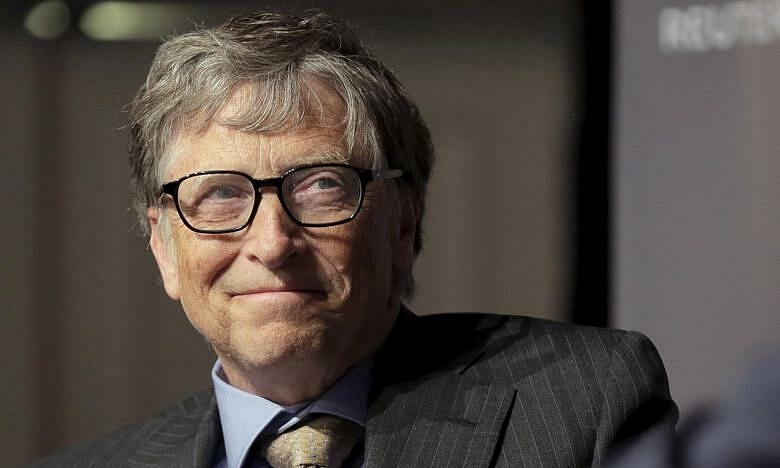

In [41]:
img_file = '/content/drive/MyDrive/Biometrics/download-jpeg-2698-1614568954-4486-4932-1684820794.jpg'
result = predict(img_file, SVM_model)
if result == -1:
  print("Unknown")
else:
  print("Actual: Bill Gates", "\nPredict:", all_names[result][0])

img = cv2.imread(img_file)
cv2_imshow(img)